# Report project: ADAM Optimizer Notebook

This project was done in the scope of the CS-439 : Optimization for ML course. The project was done by :  
- Brioschi Riccardo 
- Mossinelli Giacomo
- Havolli Albias 

### Import useful libraries

In [37]:
# Import useful libraries for computation
import numpy as np

# Import torch and libraries to deal with NN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pyhessian import hessian # Hessian computation
import copy
#from density_plot import get_esd_plot # ESD plot

# Import usefil library to visualize results
import matplotlib.pyplot as plt

# Importing the LeNet5 architecture we are going to use for our study and comparisons
from cnn_architectures import *

# Importing parameters to use with different optimizers before comparing them
import params

# Importing useful functions
from helpers import *

# Ignoring warnings to make the code more readable
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting the parameters and additional variables

In [16]:
# Defininig neural network's parameters and seed for reproducibility purposes
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
IMG_SIZE = 32
N_CLASSES = 10
# Checking device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

### Loading MNIST dataset, reshaping and plotting  data (ADAM)

In [17]:
# Loading data
transforms = transforms.Compose([transforms.Resize(IMG_SIZE),
                                 transforms.ToTensor()])

# Load the MNIST dataset
raw_mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
raw_mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

# Passing train data to the dataloader
train_loader = DataLoader(dataset=raw_mnist_trainset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=True)

# Passing test data to the dataloader
test_loader = DataLoader(dataset=raw_mnist_testset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=False)


## Loading CIFAR-10 Dataset

In [4]:
# Loading data
#transforms = transforms.Compose([transforms.Resize(IMG_SIZE),
                                 #transforms.ToTensor()])

# Load the MNIST dataset
raw_mnist_trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms)
raw_mnist_testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transforms)

# Passing train data to the dataloader
train_loader = DataLoader(dataset=raw_mnist_trainset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=True)

# Passing test data to the dataloader
test_loader = DataLoader(dataset=raw_mnist_testset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=False)

### Moving data to local device in order to visualize them (and use them later)

In [18]:
# Reshaping train data (from 28*28 to 32*32) for visualization purposes
train_data, train_target = reshape_train_data(raw_mnist_trainset, torch.device('cpu'))
# Reshaping test data (from 28*28 to 32*32) for visualization purposes
test_data, test_target = reshape_test_data(raw_mnist_trainset, torch.device('cpu'))

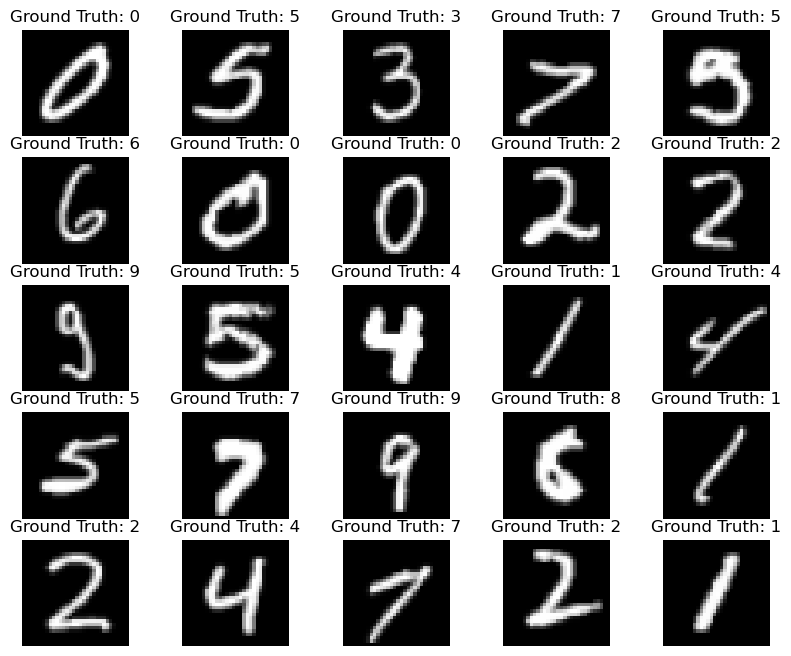

In [19]:
#plot some training examples with ground truth 
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_loader), size=(1,)).item()
    img = train_data[sample_idx]
    label = train_target[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Ground Truth: {}".format(train_target[sample_idx]))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model training and Model Evaluation using ADAM

First, we train our model using LeNet5. The model was trained using batches of size 32 and 15 epochs. Despite the low number of training episodes and iterations, the model seems to perform well.

In [45]:
# Initializing the model we are going to use in our study
model = LeNet5(num_classes=N_CLASSES).to(DEVICE)
# Defining the criterion (loss function) to be used during the training procedure
criterion = nn.CrossEntropyLoss()
# Defining and initializing the optimizer (ADAM in this notebook)
optimizer = torch.optim.Adam(model.parameters(), lr=params.ADAM_LEARNING_RATE)

Let's train and test our first model

In [46]:
model, optimizer, losses, grad_norms = training_loop(model, criterion, optimizer, train_loader, test_loader, params.ADAM_N_EPOCHS,
                                    DEVICE)

14:26:13 --- Epoch: 0	Train loss: 0.2317	Valid loss: 0.0948	Train accuracy: 97.24	Valid accuracy: 97.14
14:26:36 --- Epoch: 1	Train loss: 0.0837	Valid loss: 0.0669	Train accuracy: 98.06	Valid accuracy: 97.93
14:26:59 --- Epoch: 2	Train loss: 0.0586	Valid loss: 0.0553	Train accuracy: 98.63	Valid accuracy: 98.13
14:27:22 --- Epoch: 3	Train loss: 0.0469	Valid loss: 0.0508	Train accuracy: 98.96	Valid accuracy: 98.38
14:27:45 --- Epoch: 4	Train loss: 0.0384	Valid loss: 0.0457	Train accuracy: 99.28	Valid accuracy: 98.43
14:28:08 --- Epoch: 5	Train loss: 0.0313	Valid loss: 0.0527	Train accuracy: 99.11	Valid accuracy: 98.40
14:28:31 --- Epoch: 6	Train loss: 0.0276	Valid loss: 0.0510	Train accuracy: 99.19	Valid accuracy: 98.37
14:28:54 --- Epoch: 7	Train loss: 0.0255	Valid loss: 0.0422	Train accuracy: 99.57	Valid accuracy: 98.74
14:29:17 --- Epoch: 8	Train loss: 0.0214	Valid loss: 0.0539	Train accuracy: 99.08	Valid accuracy: 98.49
14:29:40 --- Epoch: 9	Train loss: 0.0192	Valid loss: 0.0509	Trai

Plot the gradient norm, which has been proven to be an important factor related to generalization properties of the architecture

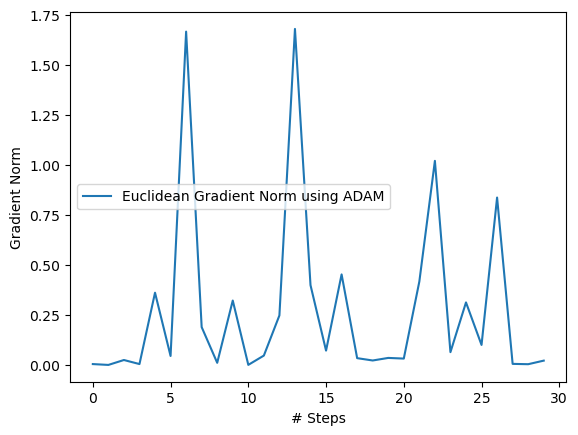

In [47]:
plot_gradient_norm(grad_norms[-30:], method = 'ADAM')

Plot the confusion matrix in order to observe the in-class accuracy

<Axes: xlabel='Predicted label', ylabel='True label'>

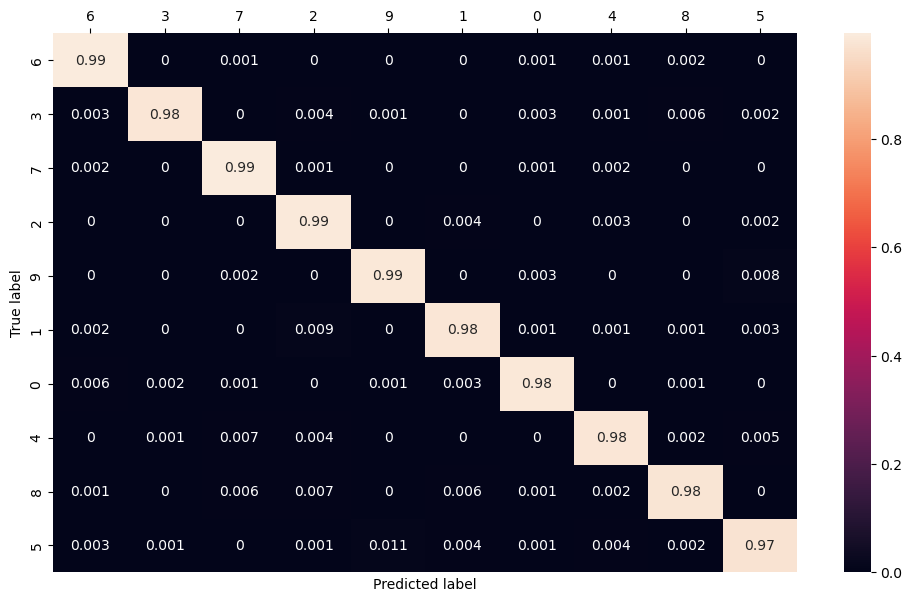

In [48]:
compute_confusion_matrix(test_loader, model, N_CLASSES)

We now start looking at the eigenvalues in order to see whether we've reached a flat or sharp minimum. The top 2 largest and smallest eigenvalue are essential in order to observe how the second order approximation behaves in the neighborhood of the point to which we have converged (we assume, as shown in the previous plot, that the firs order approximation given by the gradient is approximately zero)

In [49]:
# We now divide the training dataset into batches to compute the hessian of the loss evaluated in the solution
indices = np.random.choice(len(train_data),1000)
hessian_input, hessian_label = train_data[indices].to(DEVICE), train_target[indices].to(DEVICE)


# We now compute the hessian matrix, to later retrieve the spectral norm and the eigenvalues
device_flag = True if torch.cuda.is_available() else False
model_to_plot = copy.deepcopy(model)
criterion = torch.nn.CrossEntropyLoss()
hessian_comp = hessian(model_to_plot, criterion, data=(hessian_input, hessian_label), cuda=device_flag)

# Now let's compute the top eigenvalue. This only takes a few seconds.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=1)

# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
print("The top eigenvalue of this model is: %.4f "% (top_eigenvalues[0]))

The top eigenvalue of this model is: 2.9188 


We now plot the loss landscape. The plot below represents how the loss behaves in the directions given by the top eigenvector (direction of maximum perturbation)

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

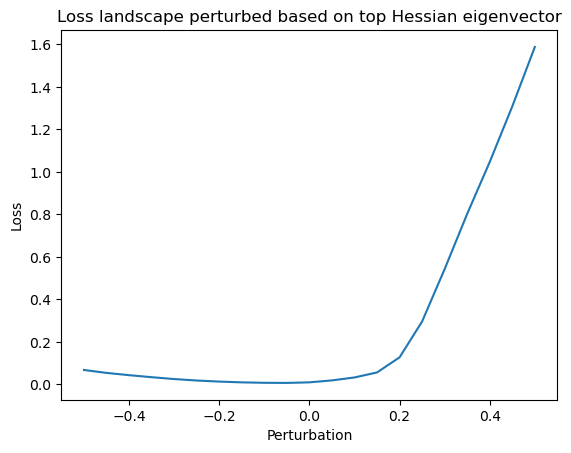

In [50]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# At first, we initialized the perturb model to be the model obtained at the end of the training procedure
model_perb = copy.deepcopy(model)

# We now perturb the function in the direction given by the top eigenvector to visualize the quality of the minimum
for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(hessian_input), hessian_label).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')

We now perturb the loss based on gradient direction

Text(0.5, 1.0, 'Loss landscape perturbed based on gradient direction')

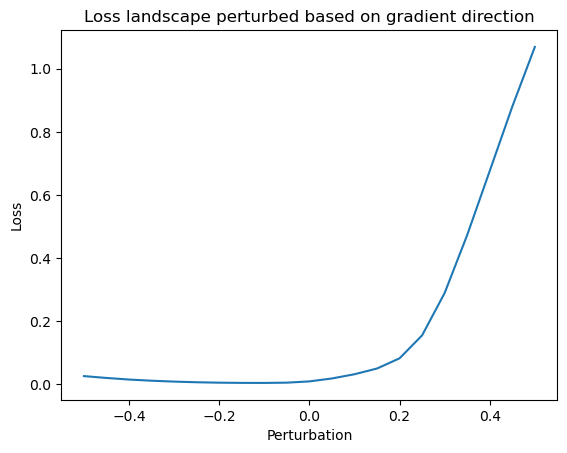

In [52]:
from pyhessian.utils import normalization


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)

# generate gradient vector to do the loss plot
loss = criterion(model_perb(hessian_input), hessian_label)
loss.backward()

v = [p.grad.data for p in model_perb.parameters()]
v = normalization(v)
model_perb.zero_grad()


for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(hessian_input), hessian_label).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on gradient direction')